<a href="https://colab.research.google.com/github/sharvaniyadav/Automated-Component-Detection-in-PCB-Manufacturing-Using-YOLOv8-Project-3/blob/main/Automated_Component_Detection_in_PCB_Manufacturing_Using_YOLOv8_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 13.1 MB/s eta 0:00:00
Mounted at /content/drive


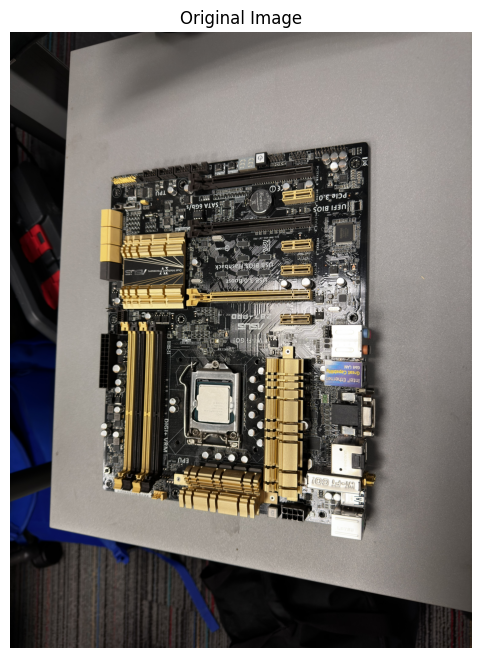

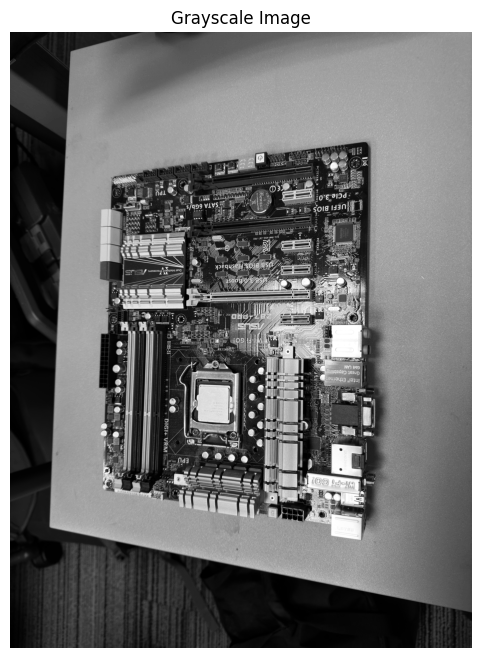

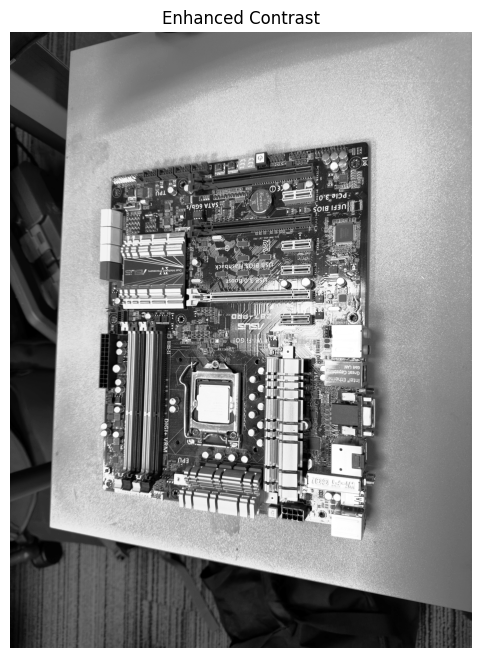

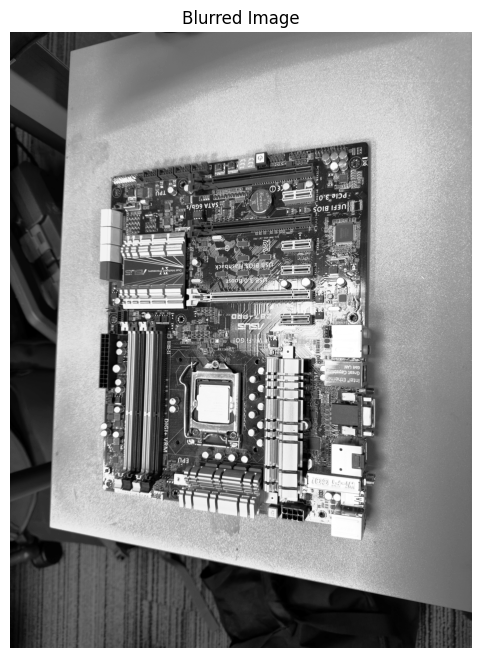

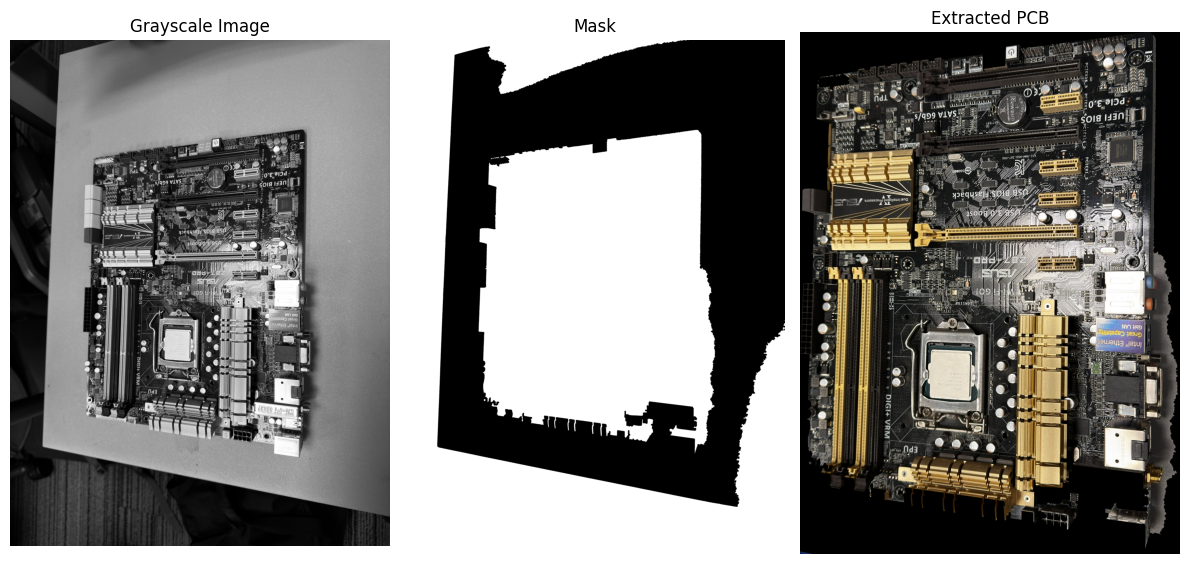

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Libraries imported successfully.


100%|██████████| 6.25M/6.25M [00:00<00:00, 52.1MB/s]


YOLOv8 Nano model loaded with pretrained weights.
Training configuration set up successfully.
Initiating the training phase. Please allow some time for completion.
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [1]:
# Install Required Libraries
!pip install ultralytics --quiet
!pip install opencv-python-headless matplotlib Pillow --quiet

# Import Libraries
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

'''Step 1: Object Masking'''

# Step 1.1: Check and Mount Google Drive to Access the Dataset
if not os.path.exists('/content/drive/MyDrive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

# Step 1.2: Define the Path to Your Image and Load It
image_path = '/content/drive/MyDrive/data/motherboard_image.JPEG'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)
if image is None:
    raise FileNotFoundError(f"Image at {image_path} could not be loaded. Check the file path.")

# Display the Original Image
plt.figure(figsize=(8, 8))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

# Step 1.3: Convert to Grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display Grayscale Image
plt.figure(figsize=(8, 8))
plt.title("Grayscale Image")
plt.imshow(grayscale_image, cmap='gray')
plt.axis("off")
plt.show()

# Step 1.4: Enhance Contrast
contrast_enhanced_image = cv2.equalizeHist(grayscale_image)

# Display Enhanced Contrast Image
plt.figure(figsize=(8, 8))
plt.title("Enhanced Contrast")
plt.imshow(contrast_enhanced_image, cmap='gray')
plt.axis("off")
plt.show()

# Step 1.5: Apply Gaussian Blur
blurred_image = cv2.GaussianBlur(contrast_enhanced_image, (5, 5), 0)

# Display Blurred Image
plt.figure(figsize=(8, 8))
plt.title("Blurred Image")
plt.imshow(blurred_image, cmap='gray')
plt.axis("off")
plt.show()

# Step 1.6: Perform Thresholding
_, binary_image = cv2.threshold(
    blurred_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

# Step 1.7: Morphological Cleaning
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
cleaned_binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

# Step 1.8: Detect and Filter Contours
contours, _ = cv2.findContours(
    cleaned_binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
filtered_contours = [c for c in contours if cv2.contourArea(c) > 50000]

if not filtered_contours:
    raise ValueError("No significant contours found. Consider adjusting parameters.")

# Step 1.9: Create a Mask
pcb_mask = np.zeros_like(grayscale_image)
cv2.drawContours(pcb_mask, filtered_contours, -1, 255, cv2.FILLED)

# Step 1.10: Refine Mask Boundaries
refinement_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
refined_mask = cv2.erode(pcb_mask, refinement_kernel, iterations=1)

# Step 1.11: Extract the PCB
extracted_pcb = cv2.bitwise_and(image, image, mask=refined_mask)

# Step 1.12: Crop the PCB
x, y, w, h = cv2.boundingRect(max(filtered_contours, key=cv2.contourArea))
cropped_pcb = extracted_pcb[y:y+h, x:x+w]

# Step 1.13: Visualize Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Grayscale Image")
plt.imshow(cv2.cvtColor(grayscale_image, cv2.COLOR_GRAY2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mask")
plt.imshow(refined_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Extracted PCB")
plt.imshow(cv2.cvtColor(cropped_pcb, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

'''Step 2: YOLOv8 Training'''

# Step 2.1: Import Necessary Libraries
from ultralytics import YOLO
print("Libraries imported successfully.")

# Step 2.2: Load the YOLOv8 Nano Model
model = YOLO('yolov8n.pt')
print("YOLOv8 Nano model loaded with pretrained weights.")

# Step 2.3: Set Up Training Configuration

dataset_config_path = '/content/drive/MyDrive/data/data.yaml'

# Training parameters
total_epochs = 120
images_per_training_batch = 8
initial_learning_rate_value = 0.0004
type_of_optimizer_used = 'AdamW'
regularization_weight_value = 0.001

# Data-related parameters
resolution_of_input_images = 960
enable_data_augmentation_process = True
enable_mixed_precision_training_mode = True

print("Training configuration set up successfully.")

# Step 2.4: Start Model Training
print("Initiating the training phase. Please allow some time for completion.")

model.train(
    name ='pcb_model_training_process',  # Custom model name
    data = dataset_config_path,           # Dataset configuration file path
    imgsz = resolution_of_input_images,   # Input image resolution
    batch = images_per_training_batch,    # Batch size for training
    epochs = total_epochs,                # Number of training epochs
    lr0 = initial_learning_rate_value,    # Initial learning rate
    optimizer = type_of_optimizer_used,   # Optimizer type
    amp = enable_mixed_precision_training_mode,  # Enable mixed precision
    augment = enable_data_augmentation_process,  # Enable data augmentation
    weight_decay = regularization_weight_value,  # Regularization term
    device=0                            # Use GPU for training
)

# Step 2.5: Monitor Training Progress
print("Model training has been successfully completed!")
